In [1]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.densenet import DenseNet121, preprocess_input
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


In [2]:
def load_images(data_dir, img_size=(224, 224)):
    images, labels = [], []
    for label in ['no', 'yes']:
        path = os.path.join(data_dir, label)
        for fname in os.listdir(path):
            if fname.lower().endswith(('jpg', 'jpeg', 'png')):
                img = cv2.imread(os.path.join(path, fname))
                if img is not None:
                    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                    img = cv2.resize(img, img_size)
                    img = preprocess_input(img)
                    images.append(img)
                    labels.append(0 if label == 'no' else 1)
    return np.array(images), np.array(labels)

data_dir = 'Dataset'
images, labels = load_images(data_dir)


In [3]:
X_train, X_temp, y_train, y_temp = train_test_split(images, labels, test_size=0.3, stratify=labels, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)


In [4]:
train_aug = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)

val_test_aug = ImageDataGenerator()

train_gen = train_aug.flow(X_train, y_train, batch_size=32)
val_gen = val_test_aug.flow(X_val, y_val, batch_size=32)
test_gen = val_test_aug.flow(X_test, y_test, batch_size=32)


In [5]:
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
output = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=output)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)       ┃ Output Shape     ┃   Param # ┃ Connected to     ┃
┡━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ input_layer        │ (None, 224, 224, │         0 │ -                │
│ (InputLayer)       │ 3)               │           │                  │
├────────────────────┼──────────────────┼───────────┼──────────────────┤
│ zero_padding2d     │ (None, 230, 230, │         0 │ input_layer[0][… │
│ (ZeroPadding2D)    │ 3)               │           │                  │
├────────────────────┼──────────────────┼───────────┼──────────────────┤
│ conv1_conv         │ (None, 112, 112, │     9,408 │ zero_padding2d[… │
│ (Conv2D)           │ 64)              │           │                  │
├────────────────────┼──────────────────┼───────────┼──────────────────┤
│ conv1_bn           │ (None, 112, 112, │       256 │ conv1_conv[0][0] │
│ (BatchNormalizati… │ 64)              │           │                  │
├────────────────────┼──────────────────┼───────────┼──────────────────┤
│ conv1_relu         │ (None, 112, 112, │         0 │ conv1_bn[0][0]   │
│ (Activation)       │ 64)              │           │                  │
├────────────────────┼──────────────────┼───────────┼──────────────────┤
│ zero_padding2d_1   │ (None, 114, 114, │         0 │ conv1_relu[0][0] │
│ (ZeroPadding2D)    │ 64)              │           │                  │
├────────────────────┼──────────────────┼───────────┼──────────────────┤
│ pool1              │ (None, 56, 56,   │         0 │ zero_padding2d_… │
│ (MaxPooling2D)     │ 64)              │           │                  │
├────────────────────┼──────────────────┼───────────┼──────────────────┤
│ conv2_block1_0_bn  │ (None, 56, 56,   │       256 │ pool1[0][0]      │
│ (BatchNormalizati… │ 64)              │           │                  │
├────────────────────┼──────────────────┼───────────┼──────────────────┤
│ conv2_block1_0_re… │ (None, 56, 56,   │         0 │ conv2_block1_0_… │
│ (Activation)       │ 64)              │           │                  │
├────────────────────┼──────────────────┼───────────┼──────────────────┤
│ conv2_block1_1_co… │ (None, 56, 56,   │     8,192 │ conv2_block1_0_… │
│ (Conv2D)           │ 128)             │           │                  │
├────────────────────┼──────────────────┼───────────┼──────────────────┤
│ conv2_block1_1_bn  │ (None, 56, 56,   │       512 │ conv2_block1_1_… │
│ (BatchNormalizati… │ 128)             │           │                  │
├────────────────────┼──────────────────┼───────────┼──────────────────┤
│ conv2_block1_1_re… │ (None, 56, 56,   │         0 │ conv2_block1_1_… │
│ (Activation)       │ 128)             │           │                  │
├────────────────────┼──────────────────┼───────────┼──────────────────┤
│ conv2_block1_2_co… │ (None, 56, 56,   │    36,864 │ conv2_block1_1_… │
│ (Conv2D)           │ 32)              │           │                  │
├────────────────────┼──────────────────┼───────────┼──────────────────┤
│ conv2_block1_conc… │ (None, 56, 56,   │         0 │ pool1[0][0],     │
│ (Concatenate)      │ 96)              │           │ conv2_block1_2_… │
├────────────────────┼──────────────────┼───────────┼──────────────────┤
│ conv2_block2_0_bn  │ (None, 56, 56,   │       384 │ conv2_block1_co… │
│ (BatchNormalizati… │ 96)              │           │                  │
├────────────────────┼──────────────────┼───────────┼──────────────────┤
│ conv2_block2_0_re… │ (None, 56, 56,   │         0 │ conv2_block2_0_… │
│ (Activation)       │ 96)              │           │                  │
├────────────────────┼──────────────────┼───────────┼──────────────────┤
│ conv2_block2_1_co… │ (None, 56, 56,   │    12,288 │ conv2_block2_0_… │
│ (Conv2D)           │ 128)             │           │                  │
├────────────────────┼──────────────────┼───────────┼──────────────────┤
│ conv2_block2_1_bn  │ (None, 56, 56,   │       512 │ conv

 Total params: 7,300,161 (27.85 MB)

 Trainable params: 262,657 (1.00 MB)

 Non-trainable params: 7,037,504 (26.85 MB)

In [6]:
callbacks = [
    EarlyStopping(patience=3, monitor='val_loss', restore_best_weights=True),
    ModelCheckpoint('best_model.keras', save_best_only=True)
]

history_initial=model.fit(train_gen, validation_data=val_gen, epochs=10, callbacks=callbacks)

# Fine-tuning
base_model.trainable = True
for layer in base_model.layers[:-50]:  # unfreeze last 50
    layer.trainable = False

model.compile(optimizer=tf.keras.optimizers.Adam(1e-5), loss='binary_crossentropy', metrics=['accuracy'])

history_fine_tune=model.fit(train_gen, validation_data=val_gen, epochs=10, callbacks=callbacks)


Epoch 1/10


C:\Users\hp\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


66/66 ━━━━━━━━━━━━━━━━━━━━ 163s 2s/step - accuracy: 0.6928 - loss: 0.6296 - val_accuracy: 0.9133 - val_loss: 0.2339
Epoch 2/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 143s 2s/step - accuracy: 0.8476 - loss: 0.3310 - val_accuracy: 0.8956 - val_loss: 0.2521
Epoch 3/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 141s 2s/step - accuracy: 0.8434 - loss: 0.3389 - val_accuracy: 0.9400 - val_loss: 0.1755
Epoch 4/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 138s 2s/step - accuracy: 0.8630 - loss: 0.3200 - val_accuracy: 0.9111 - val_loss: 0.2173
Epoch 5/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 142s 2s/step - accuracy: 0.8799 - loss: 0.2769 - val_accuracy: 0.9333 - val_loss: 0.1828
Epoch 6/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 137s 2s/step - accuracy: 0.8835 - loss: 0.2871 - val_accuracy: 0.9156 - val_loss: 0.2199
Epoch 1/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 168s 2s/step - accuracy: 0.7107 - loss: 0.7762 - val_accuracy: 0.9444 - val_loss: 0.1619
Epoch 2/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 148s 2s/step - accuracy: 0.8233 - loss: 0.4668 - val_accuracy: 0.9378 - val_loss: 0.

In [7]:
# Accuracy on Training Data
train_loss, train_acc = model.evaluate(train_gen, verbose=0)
print(f"✅ Training Accuracy: {train_acc * 100:.2f}%")

# Accuracy on Test Data
test_loss, test_acc = model.evaluate(test_gen, verbose=0)
print(f"✅ Test Accuracy: {test_acc * 100:.2f}%")


✅ Training Accuracy: 96.24%
✅ Test Accuracy: 92.67%


In [8]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import MaxNLocator

def plot_training_curves(history_initial, history_fine_tune):
    fig, axs = plt.subplots(2, 1, figsize=(12, 10), constrained_layout=True)
    epochs_initial = range(1, len(history_initial.history['accuracy']) + 1)
    epochs_fine_tune = range(len(history_initial.history['accuracy']) + 1, 
                             len(history_initial.history['accuracy']) + len(history_fine_tune.history['accuracy']) + 1)

    # Accuracy plot
    axs[0].plot(epochs_initial, history_initial.history['accuracy'], label='Initial Training Accuracy', linestyle='-', marker='o', color='#FF6F61')
    axs[0].plot(epochs_fine_tune, history_fine_tune.history['accuracy'], label='Fine-Tuning Accuracy', linestyle='-', marker='x', color='#6B5B95')
    axs[0].set_title('Model Accuracy - Initial Training vs Fine-Tuning', fontsize=14, weight='bold', color='#3C3B6E')
    axs[0].set_xlabel('Epochs', fontsize=12)
    axs[0].set_ylabel('Accuracy', fontsize=12)
    axs[0].grid(alpha=0.3)
    axs[0].legend()
    axs[0].xaxis.set_major_locator(MaxNLocator(integer=True))

    # Loss plot
    axs[1].plot(epochs_initial, history_initial.history['loss'], label='Initial Training Loss', linestyle='-', marker='o', color='#FF6F61')
    axs[1].plot(epochs_fine_tune, history_fine_tune.history['loss'], label='Fine-Tuning Loss', linestyle='-', marker='x', color='#6B5B95')
    axs[1].set_title('Model Loss - Initial Training vs Fine-Tuning', fontsize=14, weight='bold', color='#3C3B6E')
    axs[1].set_xlabel('Epochs', fontsize=12)
    axs[1].set_ylabel('Loss', fontsize=12)
    axs[1].grid(alpha=0.3)
    axs[1].legend()
    axs[1].xaxis.set_major_locator(MaxNLocator(integer=True))

    plt.suptitle('Training and Fine-Tuning Analysis', fontsize=16, weight='bold', color='#FF6F61')
    plt.show()

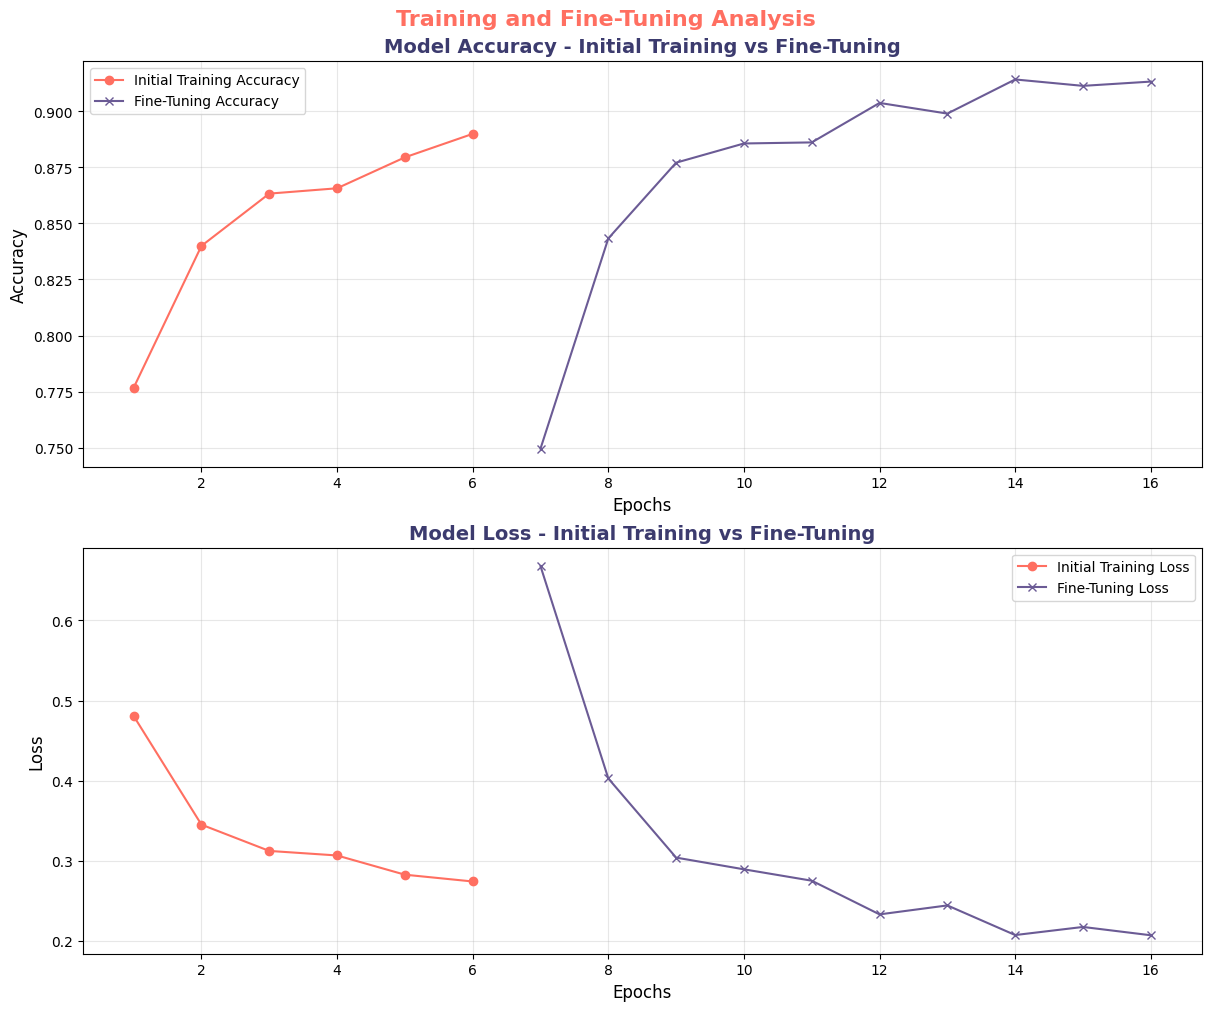

In [9]:
plot_training_curves(history_initial, history_fine_tune)

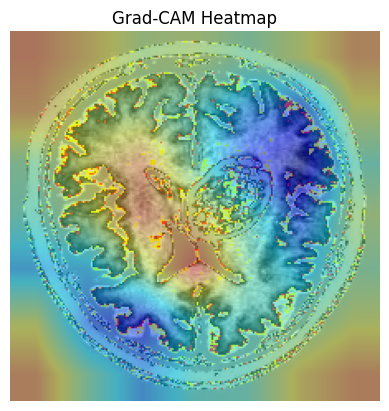

In [10]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name="conv5_block16_concat"):
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        loss = predictions[:, 0]

    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

def superimpose_heatmap(heatmap, original_image, alpha=0.4):
    heatmap = cv2.resize(heatmap, (original_image.shape[1], original_image.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    color_map = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    output = cv2.addWeighted(original_image, 1 - alpha, color_map, alpha, 0)
    return output

# Use a test image
test_img = X_test[0]
img_array = np.expand_dims(test_img, axis=0)
heatmap = make_gradcam_heatmap(img_array, model)

# Display
plt.imshow(superimpose_heatmap(heatmap, ((test_img + 1) * 127.5).astype(np.uint8)))
plt.title("Grad-CAM Heatmap")
plt.axis('off')
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


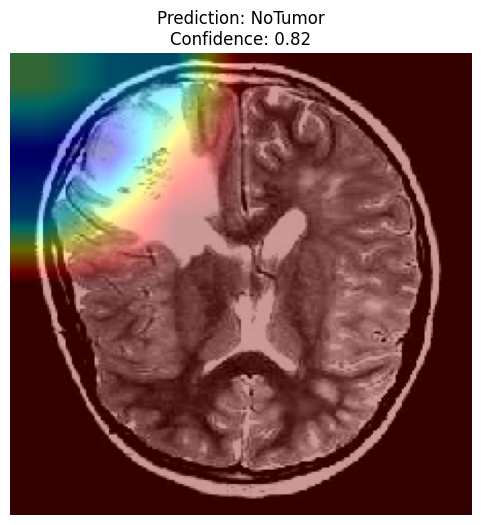

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
import cv2

# --- Step 1: Preprocess Image ---
img_path = "Dataset/yes/y0.jpg"  # Change this
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = img_array / 255.0

# --- Step 2: Make Prediction ---
pred = model.predict(img_array)[0][0]  # probability
pred_class = int(pred > 0.5)           # 0 or 1
confidence = pred if pred_class == 1 else 1 - pred


# Optional: if you have a label map
class_labels = ['NoTumor', 'Tumor']
pred_label = class_labels[pred_class]

# --- Step 3: Generate Grad-CAM ---
last_conv_layer_name = "conv5_block16_2_conv"  # Update if needed
grad_model = tf.keras.models.Model(
    [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
)

with tf.GradientTape() as tape:
    conv_outputs, predictions = grad_model(img_array)
    loss = predictions[:, pred_class]

grads = tape.gradient(loss, conv_outputs)
pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
conv_outputs = conv_outputs[0]
heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
heatmap = tf.squeeze(heatmap)
heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)

# --- Step 4: Overlay Heatmap ---
heatmap = cv2.resize(heatmap.numpy(), (224, 224))
heatmap = np.uint8(255 * heatmap)
heatmap_color = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
superimposed_img = cv2.addWeighted(np.uint8(img_array[0] * 255), 0.6, heatmap_color, 0.4, 0)

# --- Step 5: Display with Labels ---
plt.figure(figsize=(6, 6))
plt.imshow(superimposed_img)
plt.axis('off')
plt.title(f"Prediction: {pred_label}\nConfidence: {confidence:.2f}")
plt.show()


In [ ]:
pred

In [12]:
print(f"Raw prediction (sigmoid output): {pred}")
print(f"Predicted class: {pred_class} ({pred_label}), Confidence: {confidence:.2f}")


Raw prediction (sigmoid output): 0.17607568204402924
Predicted class: 0 (NoTumor), Confidence: 0.82


In [13]:
import os
from tensorflow.keras.preprocessing import image
import numpy as np

# Set paths
yes_dir = "Dataset/yes"
no_dir = "Dataset/no"

# Initialize counters
correct = 0
total = 0
class_labels = ['NoTumor', 'Tumor']

def predict_image(img_path, true_label):
    global correct, total
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0) / 255.0

    pred = model.predict(img_array)[0][0]
    pred_class = int(pred > 0.5)  # threshold = 0.5
    total += 1

    if pred_class == true_label:
        correct += 1

# Evaluate on Tumor class (label 1)
for filename in os.listdir(yes_dir):
    if filename.endswith(".jpg") or filename.endswith(".png"):
        predict_image(os.path.join(yes_dir, filename), 1)

# Evaluate on NoTumor class (label 0)
for filename in os.listdir(no_dir):
    if filename.endswith(".jpg") or filename.endswith(".png"):
        predict_image(os.path.join(no_dir, filename), 0)

# Print accuracy
print(f"Total Correct Predictions: {correct}/{total}")
print(f"Accuracy: {correct / total:.2f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1

In [14]:
#vgg

In [15]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import MaxNLocator

In [16]:
# VGG16 Model with Transfer Learning
base_model_vgg = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model_vgg.trainable = False

vgg_x = GlobalAveragePooling2D()(base_model_vgg.output)
vgg_x = Dropout(0.5)(vgg_x)
vgg_x = Dense(256, activation='relu')(vgg_x)
output_vgg = Dense(1, activation='sigmoid')(vgg_x)

model_vgg = Model(inputs=base_model_vgg.input, outputs=output_vgg)
model_vgg.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 6s 0us/step


In [17]:
# Callbacks
callbacks_vgg = [
    EarlyStopping(patience=3, monitor='val_loss', restore_best_weights=True),
    ModelCheckpoint('best_model_vgg16.keras', save_best_only=True)
]


In [18]:
# Initial Training
history_vgg_initial = model_vgg.fit(train_gen, validation_data=val_gen, epochs=10, callbacks=callbacks_vgg)

Epoch 1/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 465s 7s/step - accuracy: 0.5898 - loss: 0.6678 - val_accuracy: 0.8667 - val_loss: 0.3812
Epoch 2/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 455s 7s/step - accuracy: 0.8420 - loss: 0.3931 - val_accuracy: 0.8689 - val_loss: 0.3235
Epoch 3/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 445s 7s/step - accuracy: 0.8316 - loss: 0.3729 - val_accuracy: 0.9022 - val_loss: 0.2350
Epoch 4/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 444s 7s/step - accuracy: 0.8460 - loss: 0.3556 - val_accuracy: 0.9133 - val_loss: 0.2169
Epoch 5/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 449s 7s/step - accuracy: 0.8506 - loss: 0.3288 - val_accuracy: 0.8733 - val_loss: 0.2784
Epoch 6/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 449s 7s/step - accuracy: 0.8578 - loss: 0.3425 - val_accuracy: 0.9111 - val_loss: 0.2016
Epoch 7/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 446s 7s/step - accuracy: 0.8580 - loss: 0.3422 - val_accuracy: 0.9111 - val_loss: 0.2145
Epoch 8/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 446s 7s/step - accuracy: 0.8734 - loss: 0.2879 - val_accuracy: 0.9222 - v

In [19]:
# Fine-tuning
base_model_vgg.trainable = True
for layer in base_model_vgg.layers[:-50]:  # Unfreeze last 50 layers
    layer.trainable = False

model_vgg.compile(optimizer=tf.keras.optimizers.Adam(1e-5), loss='binary_crossentropy', metrics=['accuracy'])

history_vgg_fine_tune = model_vgg.fit(train_gen, validation_data=val_gen, epochs=10, callbacks=callbacks_vgg)

Epoch 1/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 1221s 18s/step - accuracy: 0.8935 - loss: 0.2624 - val_accuracy: 0.9578 - val_loss: 0.0881
Epoch 2/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 1209s 18s/step - accuracy: 0.9577 - loss: 0.1094 - val_accuracy: 0.9778 - val_loss: 0.0631
Epoch 3/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 1206s 18s/step - accuracy: 0.9777 - loss: 0.0587 - val_accuracy: 0.9822 - val_loss: 0.0363
Epoch 4/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 1202s 18s/step - accuracy: 0.9877 - loss: 0.0375 - val_accuracy: 0.9889 - val_loss: 0.0351
Epoch 5/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 1195s 18s/step - accuracy: 0.9856 - loss: 0.0525 - val_accuracy: 0.9956 - val_loss: 0.0108
Epoch 6/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 1206s 18s/step - accuracy: 0.9902 - loss: 0.0266 - val_accuracy: 0.9778 - val_loss: 0.0438
Epoch 7/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 1199s 18s/step - accuracy: 0.9950 - loss: 0.0180 - val_accuracy: 0.9978 - val_loss: 0.0073
Epoch 8/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 1194s 18s/step - accuracy: 0.9892 - loss: 0.0299 - val_accu

In [20]:
# Plotting Training Curves
def plot_training_curves(history_initial, history_fine_tune):
    fig, axs = plt.subplots(2, 1, figsize=(12, 10), constrained_layout=True)
    epochs_initial = range(1, len(history_initial.history['accuracy']) + 1)
    epochs_fine_tune = range(len(history_initial.history['accuracy']) + 1, 
                             len(history_initial.history['accuracy']) + len(history_fine_tune.history['accuracy']) + 1)

    # Accuracy plot
    axs[0].plot(epochs_initial, history_initial.history['accuracy'], label='Initial Training Accuracy', linestyle='-', marker='o', color='#FF6F61')
    axs[0].plot(epochs_fine_tune, history_fine_tune.history['accuracy'], label='Fine-Tuning Accuracy', linestyle='-', marker='x', color='#6B5B95')
    axs[0].set_title('Model Accuracy - Initial Training vs Fine-Tuning', fontsize=14, weight='bold', color='#3C3B6E')
    axs[0].set_xlabel('Epochs', fontsize=12)
    axs[0].set_ylabel('Accuracy', fontsize=12)
    axs[0].grid(alpha=0.3)
    axs[0].legend()
    axs[0].xaxis.set_major_locator(MaxNLocator(integer=True))

    # Loss plot
    axs[1].plot(epochs_initial, history_initial.history['loss'], label='Initial Training Loss', linestyle='-', marker='o', color='#FF6F61')
    axs[1].plot(epochs_fine_tune, history_fine_tune.history['loss'], label='Fine-Tuning Loss', linestyle='-', marker='x', color='#6B5B95')
    axs[1].set_title('Model Loss - Initial Training vs Fine-Tuning', fontsize=14, weight='bold', color='#3C3B6E')
    axs[1].set_xlabel('Epochs', fontsize=12)
    axs[1].set_ylabel('Loss', fontsize=12)
    axs[1].grid(alpha=0.3)
    axs[1].legend()
    axs[1].xaxis.set_major_locator(MaxNLocator(integer=True))

    plt.suptitle('Training and Fine-Tuning Analysis', fontsize=16, weight='bold', color='#FF6F61')
    plt.show()

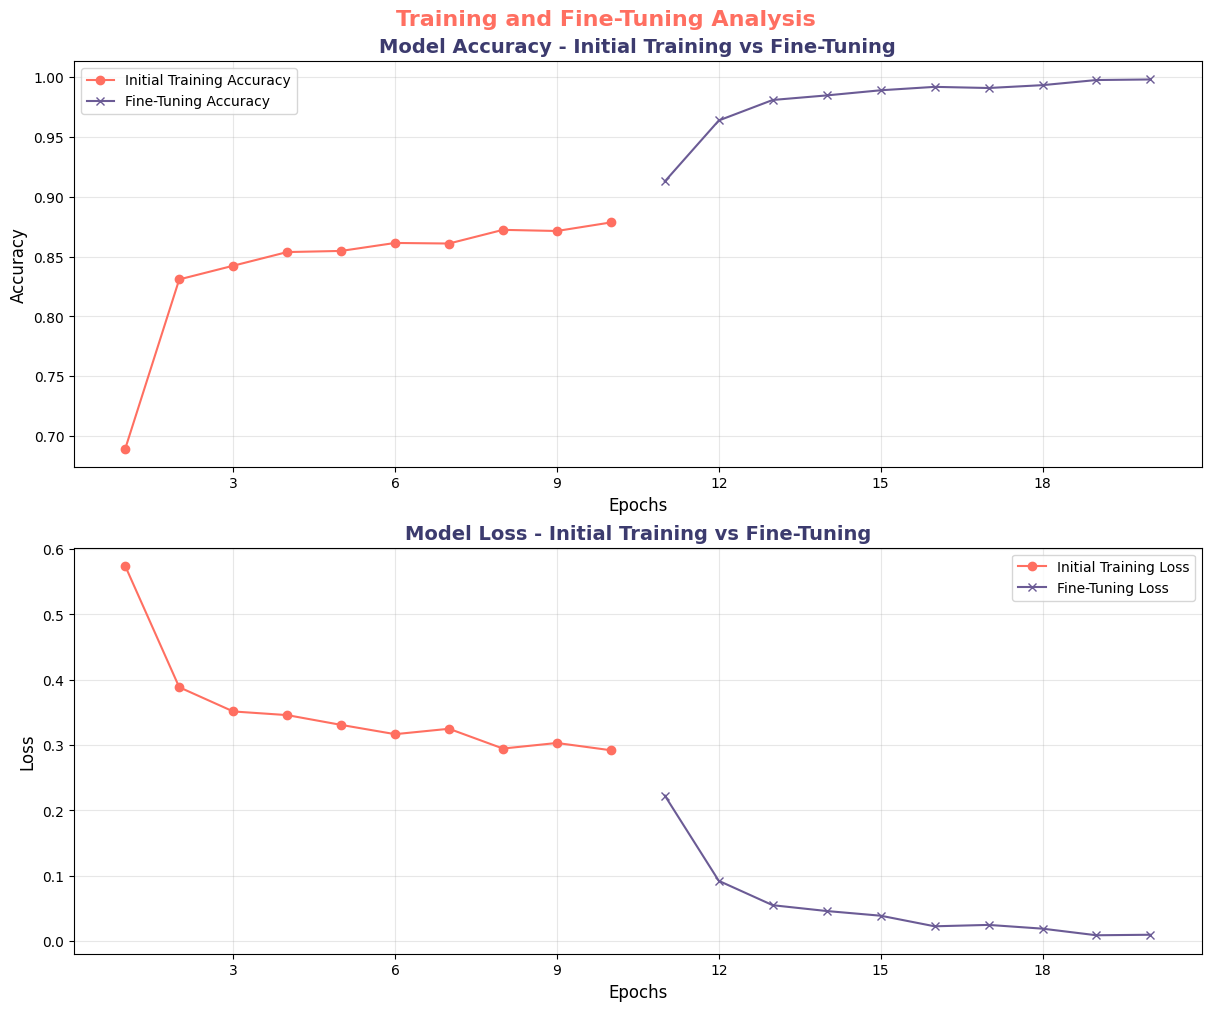

In [21]:
plot_training_curves(history_vgg_initial, history_vgg_fine_tune)

In [22]:
# Evaluate on training and test data
train_loss, train_acc = model_vgg.evaluate(train_gen, verbose=0)
test_loss, test_acc = model_vgg.evaluate(test_gen, verbose=0)

print(f"Training Accuracy: {train_acc:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")

Training Accuracy: 0.9981
Test Accuracy: 0.9889


In [23]:
# Save the trained model
model_vgg.save('final_model_vgg16.keras')

15/15 ━━━━━━━━━━━━━━━━━━━━ 75s 5s/step


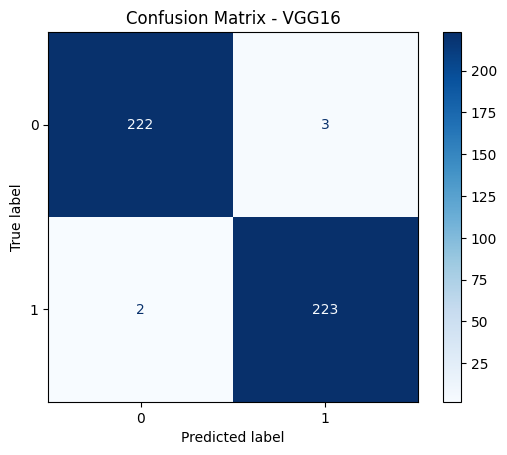

In [28]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Predictions for Confusion Matrix
y_true = np.concatenate([test_gen[i][1] for i in range(len(test_gen))])
preds = model_vgg.predict(test_gen)
y_pred = (preds > 0.5).astype(int).flatten()

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
display = ConfusionMatrixDisplay(confusion_matrix=cm)
display.plot(cmap='Blues')
plt.title('Confusion Matrix - VGG16')
plt.show()

# Example usage:
#plot_training_curves(history_vgg_initial, history_vgg_fine_tune)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


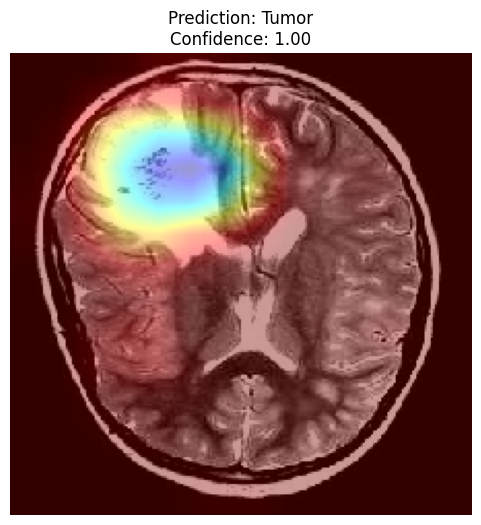

In [51]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
import tensorflow as tf
import cv2

# --- Step 1: Preprocess Image ---
img_path = "Dataset/yes/y0.jpg"  # Change this
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = img_array / 255.0

# --- Step 2: Make Prediction ---
pred = model_vgg.predict(img_array)[0][0]  # probability
pred_class = int(pred > 0.5)           # 0 or 1
confidence = pred if pred_class == 1 else 1 - pred

# Optional: if you have a label map
class_labels = ['No Tumor', 'Tumor']
pred_label = class_labels[pred_class]

# --- Step 3: Generate Grad-CAM ---
last_conv_layer_name = "block5_conv3"  # Last conv layer in VGG
grad_model = tf.keras.models.Model(
    [model_vgg.inputs], [model_vgg.get_layer(last_conv_layer_name).output, model_vgg.output]
)

with tf.GradientTape() as tape:
    conv_outputs, predictions = grad_model(img_array)
    loss = predictions[0]

grads = tape.gradient(loss, conv_outputs)
pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
conv_outputs = conv_outputs[0]

# Weighted sum
heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
heatmap = tf.squeeze(heatmap)

# Normalize the heatmap
heatmap = tf.maximum(heatmap, 0) / (tf.reduce_max(heatmap) + 1e-10)
heatmap = heatmap.numpy()

# --- Step 4: Overlay Heatmap ---
# Resize the heatmap to match the input image size
heatmap = cv2.resize(heatmap, (224, 224))
heatmap = np.uint8(255 * heatmap)

# Apply colormap
heatmap_color = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

# Superimpose heatmap onto the original image
original_img = np.uint8(img_array[0] * 255)
superimposed_img = cv2.addWeighted(original_img, 0.6, heatmap_color, 0.4, 0)

# --- Step 5: Display with Labels ---
plt.figure(figsize=(6, 6))
plt.imshow(superimposed_img)
plt.axis('off')
plt.title(f"Prediction: {pred_label}\nConfidence: {confidence:.2f}")
plt.show()
